In [59]:
import numpy as np
from matplotlib import cm, pyplot as plt
from sympy import Symbol
from sympy.solvers import solve as solve_symbolic

# 1
## a)

In [32]:
def central_difference_matrix(M, N, d):
    """
    :param M: number of grid points along the x-axis
    :param N: number of grid points along the y-axis
    :param d: direction
    :return: Central difference matrix approximating twice derivative along d
    """

    x, y = d

    offset = (M-1) * y + x

    A = -2 * np.eye((N-1)*(M-1))

    off_diag = np.ones((N-1)*(M-1)-offset)
    if x:
        off_diag[M-2::M-1] = 0
    A += np.diag(off_diag, k=offset) + np.diag(off_diag, k=-offset)

    return A

In [33]:
def boundary_conditions(g, a, M, N, x, y):
    """

    Adjust rhs wrt boundary. Fattens bndry if Nk≠2.

    :param g: g=(g0, g1, g2, g3) tuple of functions defined on the boundary
    :param x: array from 0 to 1 of size M+1
    :param y: array from 0 to 2 of size N+1
    :return: adjustments to the rhs for elements close to the boundary
    """
    g0, g1, g2, g3 = g
    rhs = np.zeros((N-1, M-1))

    # Adjust for derivative along d1
    rhs[:, 0] += a*g1(y[1:-1])  # Left
    rhs[:, -1] += a*g2(y[1:-1])  # Right

    # Adjust for derivative along d2
    rhs[0, :] += g0(x[:-2])  # Bottom
    rhs[-1, :] += g3(x[2:])  # Top
    rhs[1:, 0] += g1(y[1:-2])  # Left, skip first entry to avoid overlap with bottom
    rhs[:-1, -1] += g2(y[2:-1])  # Right, skip last entry to avoid overlap with top

    return rhs.reshape((N-1)*(M-1))

In [34]:
def solve(a, d, g, f, r, M, N=None):
    """
    :param d: tuple of vectors (d1, d2) specifying the direction of the heat flows
    :param g: g=(g0, g1, g2, g3) tuple of functions defined on the boundary
    :param f: rhs of the analytic equation
    :return: meshgrid (X, Y) and numeric solution u on the interior
    """

    if N is None:
        N = M

    x, h = np.linspace(0, 1, M+1, retstep=True)
    y = np.linspace(0, r*h*N, N+1)  # Fattens the bndry if kN≠2

    X, Y = np.meshgrid(x[1:-1], y[1:-1])

    d1, d2 = d
    A = - a*central_difference_matrix(M, N, d1)/h**2-central_difference_matrix(M, N, d2)/h**2
    rhs = f(X, Y).reshape((N-1)*(M-1))
    rhs += boundary_conditions(g, a, M, N, x, y)/h**2

    u = np.linalg.solve(A, rhs).reshape((N-1, M-1))

    return X, Y, u

In [35]:
def subplots_3d(nrows=1, ncols=1, **fig_kw):
    return plt.subplots(nrows, ncols, subplot_kw={"projection": "3d"}, **fig_kw)


def plot_solution(X, Y, u, ax=None, txt='Solution'):
    # Plot the solution of the stationary heat equation

    if ax is None:
        _, ax = subplots_3d()

    ax.plot_surface(X, Y, u, cmap=cm.coolwarm)
    #ax.view_init(azim=30)  # Rotate the figure
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(txt)

In [36]:
def boundaries(T):
    def g0(x):  # Bottom
        return T(x, 0)

    def g1(y):  # Left
        return T(0, y)

    def g2(y):  # Right
        return T(1, y)

    def g3(x):  # Top
        return T(x, 2)

    return g0, g1, g2, g3

In [37]:
def T1(x, y):
    return np.exp(-x-1/2*y)

def f1(x, y):
    return -(r + a+1 + 0.25*r**2) * T1(x, y)

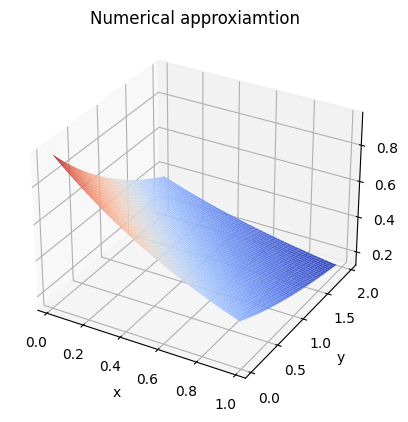

In [38]:
a = 1.3
r = 2
d1 = (1, 0)
d2 = (1, 1)  # Adjusted after the grid, taking r into account (is actually (1, r))
d = d1, d2

M = 50

g = boundaries(T1)
X, Y, u = solve(a, d, g, f1, r, M)

plot_solution(X, Y, u, txt="Numerical approxiamtion")

In [39]:
def T2(x, y):
    return 0.5 * x * (1-x)

def f2(x, y):
    return np.full_like(x, a + 1)

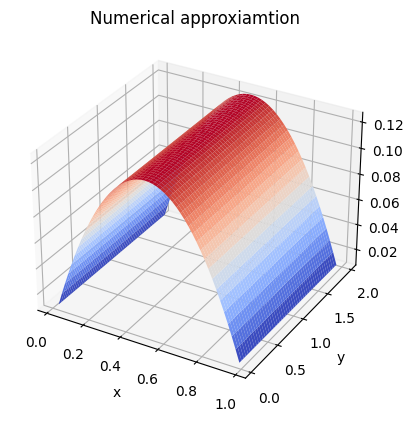

In [40]:
g = boundaries(T2)
X, Y, u = solve(a, d, g, f2, r, M)

plot_solution(X, Y, u, txt="Numerical approxiamtion")

## c)

In [41]:
def loglogplot_error(h, e, ax=None):

    if ax is None:
        _, ax = plt.subplots()

    p = np.polyfit(np.log(h), np.log(e), 1)[0]

    ax.set_title("Error")
    ax.loglog(h, e, label=f"p={p:.3f}")
    ax.set_xlabel("h")
    ax.set_ylabel("e")
    ax.invert_xaxis()
    plt.legend()
    return plt

For the analytic solution
$$
T_2(x, y) = \frac{1}{2} x (1-x)
$$
we expect no/machine error

<module 'matplotlib.pyplot' from '/Users/martinsauewinther/progging/ntnu/numdiff_p1/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

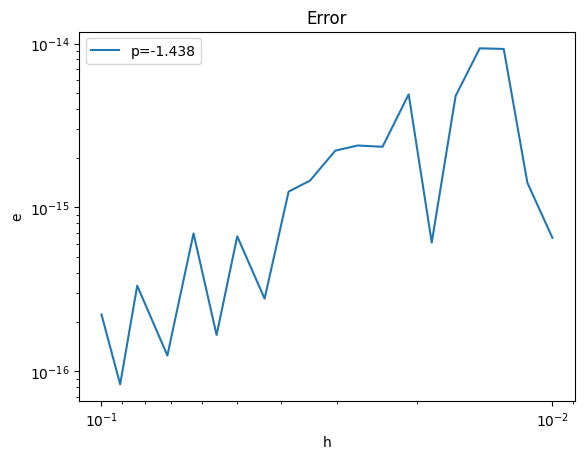

In [42]:
M = np.logspace(1, 2, 20, dtype=int)
h = 1/M
e = np.empty_like(h)

g = boundaries(T2)

for i in range(len(M)):
    X, Y, u = solve(a, d, g, f2, r, M[i])
    e[i] = np.max(np.abs(u-T2(X, Y)))

loglogplot_error(h, e)

For any other function, we expect it to be a function of $h^2$:

<module 'matplotlib.pyplot' from '/Users/martinsauewinther/progging/ntnu/numdiff_p1/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

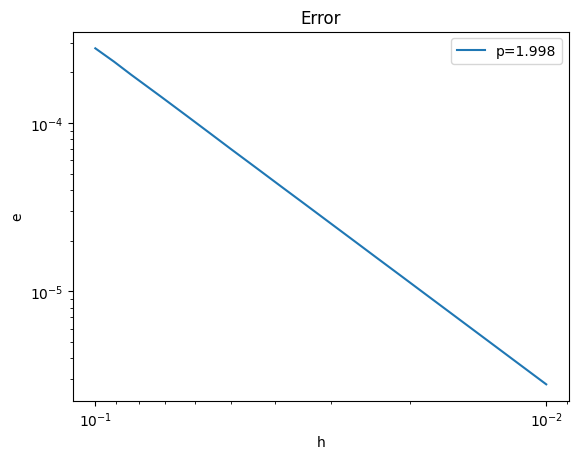

In [43]:
M = np.logspace(1, 2, 20, dtype=int)
h = 1/M
e = np.empty_like(h)
g = boundaries(T1)

for i in range(len(M)):
    X, Y, u = solve(a, d, g, f1, r, M[i])
    e[i] = np.max(np.abs(u-T1(X, Y)))

loglogplot_error(h, e)

In [44]:
def T3(x, y):
    return np.sin(0.5*np.pi*y)

def f3(x, y):
    return 1 / 4 *r**2* np.pi**2 *np.sin(1 / 2 *np.pi* y)

<module 'matplotlib.pyplot' from '/Users/martinsauewinther/progging/ntnu/numdiff_p1/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

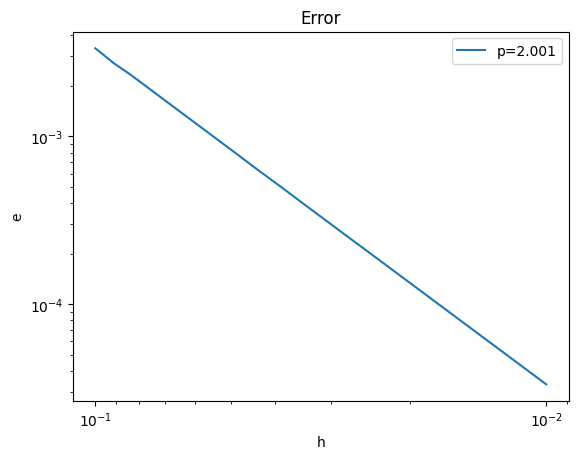

In [45]:
g = boundaries(T3)

for i in range(len(M)):
    X, Y, u = solve(a, d, g, f3, r, M[i])
    e[i] = np.max(np.abs(u-T3(X, Y)))

loglogplot_error(h, e)

## d)

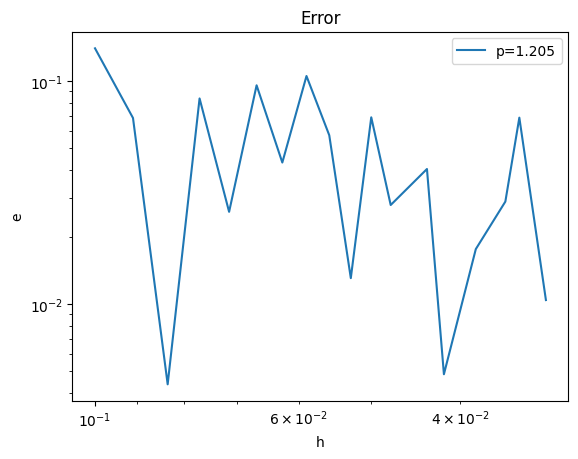

In [46]:
r = np.sqrt(2)

g = boundaries(T3)

M = np.logspace(1, 1.5, 20, dtype=int)
N = np.array(2*M/r, dtype=int) + 1
h = 1/M
e = np.empty_like(h)

for i in range(len(M)):
    X, Y, u = solve(a, d, g, f3, r, M[i], N[i])
    e[i] = np.max(np.abs(u-T3(X, Y)))

loglogplot_error(h, e)

While, again for $T_2$, we get machine error:

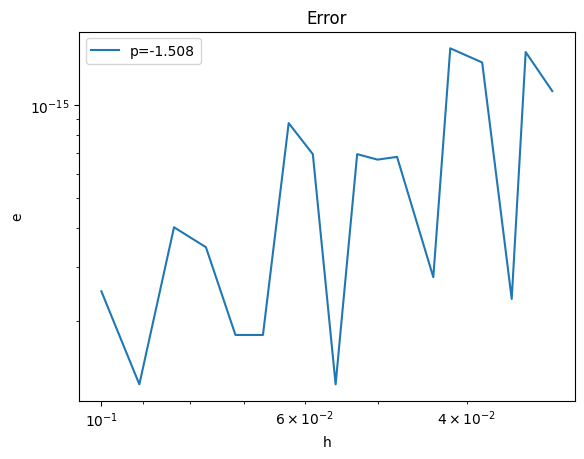

In [47]:
r = np.sqrt(2)

g = boundaries(T2)

M = np.logspace(1, 1.5, 20, dtype=int)
N = np.array(2*M/r, dtype=int) + 1
h = 1/M
e = np.empty_like(h)

for i in range(len(M)):
    X, Y, u = solve(a, d, g, f2, r, M[i], N[i])
    e[i] = np.max(np.abs(u-T2(X, Y)))

loglogplot_error(h, e)

# 2

In [54]:
def isreal(num):
    '''
    :param num: number which we want to check is real or not
    '''
    if num.imag != 0:
        result = False
    else:
        result = True

def get_projection_point(p: tuple):
    '''
    :param p: A tuple reåresenting the point from which we want to project onto 1-x^2
    '''
    r = Symbol('r')
    sol = solve_symbolic(p[0] + r*(1 - 2*p[1]) - 2*r**3, r)
    r = float(sol[0])
    return (r, 1-r**2)

def unpack_interior_nodes(vec, end_pts):
    '''
    Unpacks a 1D vector to a 2D meshgrid
    :param vec: 1d vector contianing values
    :param end_pts: array containint indexes of each rows rightmost interior point
    :return: 2d array of vec's values (0 where vec is not defined)
    '''
    N = end_pts[-1]
    if len(vec) != N:
        raise ValueError(f"Incorrect shape: {len(vec)}. Expected: {N}")

    grid = np.zeros(shape=(len(end_pts)+2, len(end_pts)+2))

    end_pts = np.insert(end_pts, 0, 0) # Prepend 0
    for i, n in enumerate(end_pts[:-1]):
        grid[i+1, 1:np.diff(end_pts)[i]+1] = vec[n:end_pts[i+1]]


    return grid

def pack_interior_nodes(grid, end_pts):
    '''
    Packs a 2d grid into a 1d vector, only keeping end_pts[i] nodes
    at row i. Note that grid[0] corresponds to x = 0 and so on
    :param grid: 2d array containing values on a grid
    :param end_pts: array containint indexes of each rows rightmost interior point
    :return: 1d array of interior nodes on the grid
    '''

    N = end_pts[-1]
    expected_shape = (len(end_pts) + 2, len(end_pts) + 2)
    if grid.shape != expected_shape:
        raise ValueError(f"Incorrect shape: {grid.shape}. Expected: ({expected_shape})")

    # We are only interrested in interior points
    grid = grid[1:-1, 1:]

    end_pts = np.insert(end_pts, 0, 0) # Prepend 0
    vec = np.zeros(N)
    print(end_pts)
    for i, row in enumerate(grid):
        vec[end_pts[i]:end_pts[i+1]] = row[:np.diff(end_pts)[i]]

    return vec

In [55]:
def central_difference_matrix_irregular_bndry(end_pts, **kwargs):
    """
    Valid kwargs:
        :x_grid: M+1 array linspace from 0 to 1 with M steps
        :y_grid: M+1 array linspace from 0 to 1 with M steps
        :modified_scheme: Bool, create a matrix for the modified disretization-scheme
    :param endpoints: array containing rightmost interior endpoint index
    :return: Central difference matrix approximating twice derivative along x and y
                using the iregular domain
    """
    mod_scheme = False
    if "modified_scheme" in kwargs and not ("x_grid" and "y_grid" and "h"in kwargs):
        raise ValueError("Please add x-, y-grid and h to use modified scheme")
    elif kwargs.get("modified_scheme"):
        mod_scheme = True
        x_grid = kwargs.get("x_grid")
        y_grid = kwargs.get("y_grid")
        h = kwargs.get("h")

    def B(n, lower_diag=None, diag=None):
        '''
        Create a tridiag(lower_diag, diag, 1) block.
        :param n: dimention of block
        :param lower_diag: n-1 array with values for lower diag
        :param diag: n array with values for diag
        '''
        upper_diag = np.repeat(1.0, n-1)
        if lower_diag is None:
            lower_diag = np.copy(upper_diag)
        if diag is None:
            diag = np.repeat(-4.0, n)
        return np.diag(lower_diag, -1) + np.diag(diag, 0) + np.diag(upper_diag, 1)
    def I(m, n, vals):
        '''Create an m*n block with vals (can be 1) along the diagonal and 0 else'''
        A = np.zeros(shape=(m, n))
        np.fill_diagonal(A, vals)
        return A


    N = end_pts[-1]
    A = np.zeros(shape=(N, N))
    end_pts = np.insert(end_pts, 0, 0) # Prepend 0

    # Iterate "blocks" down A
    for i, _ in enumerate(end_pts[:-1]):
        range_i = np.arange(end_pts[i], end_pts[i+1])
        n = np.diff(end_pts)[i] # number of interior points at row i
        m = n - np.diff(end_pts)[i+1] if i < len(end_pts)-2 else n # number of righ.pts without interior nodes above

        # Left-offset block
        if i > 0:
            if mod_scheme:
                diag = np.ones(n)

                # Iterate over rightmost point without interior nodes above
                for j, xi in enumerate(x_grid[1+n-m:1+n]):
                    diag[-m+j] = innward(eta1(xi, y_grid[i+1], h))
                left_block = I(np.diff(end_pts)[i], np.diff(end_pts)[i-1], diag)
            else:
                left_block = I(np.diff(end_pts)[i], np.diff(end_pts)[i-1], 1)
            A[
                range_i,
                end_pts[i-1]:end_pts[i]
            ] = left_block

        # Right-offset block
        if i < len(end_pts)-2:
            A[
                range_i,
                end_pts[i+1]:end_pts[i+2]
            ] = I(np.diff(end_pts)[i], np.diff(end_pts)[i+1], 1)

        # Center/Diagonal block
        if mod_scheme:
            diag = np.repeat(-4.0, n)
            lower_diag = np.repeat(1.0, n-1)

            # Correct for the right boundry
            eta0_i = eta0(x_grid[np.diff(end_pts)[i]], y_grid[i+1], h)
            diag[-1]        += 2 - at(eta0_i)
            lower_diag[-1]   = innward(eta0_i)

            # Iterate over the rightmost points without interior nodes above, and
            # correct for the upper boundry
            # m = n - np.diff(end_pts)[i+1] if i < len(end_pts)-2 else 0
            for j, xi in enumerate(x_grid[n-m+1:n+1]):
                diag[-m+j] += 2 - innward(eta1(xi, y_grid[i+1], h))

            center_block = B(n, lower_diag, diag)
        else:
            center_block = B(n)
        A[
            range_i,
            end_pts[i]:end_pts[i+1]
        ] = center_block

    return A

#
#   Functions for modified disretization scheme
#
def outward(eta: float) -> float:
    return 2 / (eta*(eta + 1))
def innward(eta: float) -> float:
    return 2 / (eta + 1)
def at(eta: float) -> float:
    return 2 / eta

def eta0(x: float, y: float, h: float) -> float:
    '''Finds horizontal eta given a spatial point x, y. And stepsize h'''
    return (np.sqrt(1-y) - x) / h
def eta1(x: float, y: float, h: float) -> float:
    '''Finds vertical eta given a spatial point x, y. And stepsize h'''
    return ((1-x**2) - y) / h


In [56]:
def boundry_conditions(g, end_pts, x_grid, y_grid, **kwargs):
    """

    Adjust rhs wrt boundary

    :param g: g=(g0, g1, g2) tuple of functions defined on the boundary
    :param endpoints: array containing rightmost interior endpoint index
    :param x_grid: array from 0 to 1 of size M+1
    :param y_grid: array from 0 to 1 of size M+1
    :return: adjustments to the rhs for elements close to the boundary
    """
    mod_scheme = False
    if kwargs.get("modified_scheme"):
        mod_scheme = True
        h = kwargs.get("h")

    def bndry_at_y(y):
        '''Given a y, return the tuple coordinate of boundry'''
        return (np.sqrt(1-y), y)
    def bndry_at_x(x):
        '''Given a x, return the tuple coordinate of boundry'''
        return (x, 1-x**2)

    g0, g1, g2 = g

    N = end_pts[-1]
    end_pts = np.insert(end_pts, 0, 0)
    rhs = np.zeros(N)

    # Create rhs by iterating over sections/blocks
    for i, n in enumerate(end_pts[:-1]):
        block = np.zeros(np.diff(end_pts)[i])
        y = y_grid[i+1]

        # Bottom boundry
        if i == 0:
            block += g0(x_grid[1:-1])

        # Left and right boundry
        block[0] += g1(y_grid[i+1])
        if mod_scheme:
            block[-1] += outward(eta0(x_grid[len(block)], y, h)) * g2(bndry_at_y(y)[0])
        else:
            block[-1] += g2(x_grid[len(block)+1])

        # Top boundry
        # Iterate over the rightmost points with boundry above
        m = np.diff(end_pts)[i]-np.diff(end_pts)[i+1] if i < len(end_pts)-2 else np.diff(end_pts)[-1] # number of righ.pts without interior nodes above
        for j, xi in enumerate(x_grid[len(block)-m: len(block)]):
            if mod_scheme:
                block[-m+j] += outward(eta1(xi, y, h)) * g2(bndry_at_x(xi)[1])
            else:
                block[-m+j] += g2(get_projection_point((xi, y_grid[i+1]))[0])

        rhs[n:end_pts[i+1]] = block

    return rhs


def get_rhs(f, g, end_pts, x_grid, y_grid, **kwargs):
    '''
    Create the rhs b-vector containing boundry conditions and rhs analytic.
    '''
    N = end_pts[-1]
    rhs = np.zeros(N)

    h = x_grid[1] - x_grid[0]

    rhs += -boundry_conditions(g, end_pts, x_grid, y_grid, **kwargs)/h**2

    X, Y = np.meshgrid(x_grid, y_grid)
    rhs += pack_interior_nodes(f(X, Y), end_pts)

    return rhs


def solve(g, f, M, **kwargs):
    """
    :param g: g=(g0, g1, g2, g3) tuple of functions defined on the boundary
    :param f: rhs of the analytic equation
    :return: meshgrid (X, Y) and numeric solution u on the interior
    """
    x_grid, h = np.linspace(0, 1, M+1, retstep=True)
    y_grid = np.linspace(0, 1, M+1)
    X, Y = np.meshgrid(x_grid, y_grid)

    kwargs["x_grid"] = x_grid
    kwargs["y_grid"] = y_grid
    if kwargs.get("modified_scheme"):
        kwargs["h"] = h

    # TODO: create a separate function perfoming this tast vvvvvv
    # Find the number of interior points at each y
    end_pts = np.zeros(M-1, dtype=np.int64)
    for i, y in enumerate(y_grid[1:-1]):
        # n = (np.sqrt(1-y)-(np.sqrt(1-y))%h)/h
        # endpoint_at_row[i] = endpoint_at_row[i-1]
        # endpoint_at_row[i] += n if n*h != np.sqrt(1-y) else n-1
        end_pts[i] = np.floor(np.sqrt((1-y))/h - 1e-6)
    end_pts = np.add.accumulate(end_pts)

    A = central_difference_matrix_irregular_bndry(end_pts, **kwargs)/h**2
    rhs = get_rhs(f, g, end_pts, **kwargs)

    u = unpack_interior_nodes(np.linalg.solve(A, rhs), end_pts)

    return X, Y, u

In [57]:
def general_boundries(T):
    def g0(x):  # Bottom
        return T(x, 0)

    def g1(y):  # Left
        return T(0, y)

    def g2(x):  # Top
        return T(x, 1-x**2)

    return g0, g1, g2

## Fattening the boundary

[   0   49   97  145  192  239  285  331  376  421  465  509  552  595
  637  678  719  759  798  837  875  913  950  986 1022 1057 1091 1124
 1157 1189 1220 1250 1279 1308 1336 1363 1389 1414 1438 1461 1483 1504
 1523 1541 1558 1573 1587 1599 1608 1615]
[   0   49   97  145  192  239  285  331  376  421  465  509  552  595
  637  678  719  759  798  837  875  913  950  986 1022 1057 1091 1124
 1157 1189 1220 1250 1279 1308 1336 1363 1389 1414 1438 1461 1483 1504
 1523 1541 1558 1573 1587 1599 1609 1616]


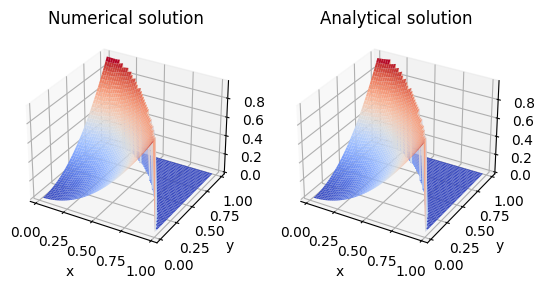

In [60]:
M = 50

def T4(x, y):
    return x**2 + y**2


def f4(x, y):
    return np.full_like(x, 4)

g = general_boundries(T4)

X, Y, u = solve(g, f4, M, modified_scheme=False, h=1/M)

x_grid = X[0, :]
h = x_grid[1] - x_grid[0]

# TODO: create a separate function perfoming this tast vvvvvv
# Find the number of interior points at each y
endpoint_at_row = np.zeros(M-1, dtype=np.int64)
for i, x in enumerate(x_grid[1:-1]):
    n = (np.sqrt(1-x)-np.sqrt(1-x)%h)/h
    endpoint_at_row[i] = endpoint_at_row[i-1]
    endpoint_at_row[i] += n if n*h != np.sqrt(1-x) else n-1

_, (ax1, ax2) = subplots_3d(ncols=2)

exact_sol = unpack_interior_nodes(pack_interior_nodes(T4(X, Y), endpoint_at_row), endpoint_at_row)

plot_solution(X[1:-1, 1:-1], Y[1:-1, 1:-1], u[1:-1, 1:-1], ax1, "Numerical solution")
plot_solution(X[1:-1, 1:-1], Y[1:-1, 1:-1], exact_sol[1:-1, 1:-1], ax2, "Analytical solution")

## Error fattened boundaries

[ 0  9 17 25 32 39 45 50 54 57]
[ 0  9 17 25 32 39 45 50 54 57]
[  0  13  25  37  48  59  69  78  87  95 102 108 113 116]
[  0  13  25  37  48  59  69  78  87  95 102 108 113 116]
[  0  18  35  52  68  84  99 114 128 141 154 166 177 187 196 204 211 217
 221]
[  0  18  35  52  68  84  99 114 128 141 154 166 177 187 196 204 211 217
 221]
[  0  27  53  79 104 129 153 177 200 223 245 266 287 307 326 345 363 380
 396 411 425 438 450 461 471 480 487 492]
[  0  27  53  79 104 129 153 177 200 223 245 266 287 307 326 345 363 380
 396 411 425 438 450 461 471 480 487 492]
[  0  38  75 112 148 184 219 254 288 322 355 388 420 451 482 512 541 570
 598 625 652 678 703 727 751 774 796 817 837 856 874 891 907 922 935 947
 957 965 971]
[  0  38  75 112 148 184 219 254 288 322 355 388 420 451 482 512 541 570
 598 625 652 678 703 727 751 774 796 817 837 856 874 891 907 922 935 947
 957 965 971]


<module 'matplotlib.pyplot' from '/Users/martinsauewinther/progging/ntnu/numdiff_p1/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

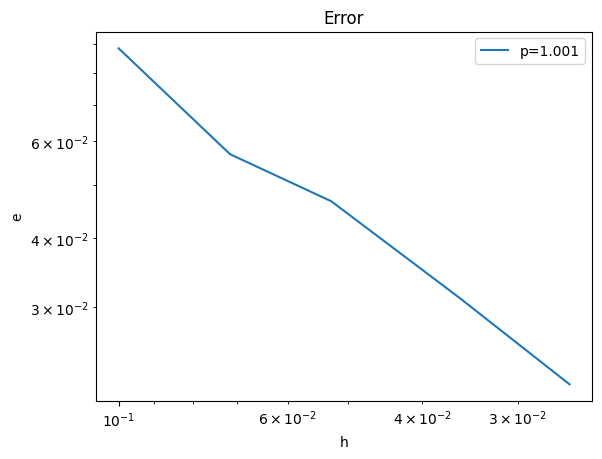

In [61]:
M_arr = np.logspace(1, 1.6, 5, dtype=int)
h_arr = 1/M_arr
e = np.empty_like(h_arr)

for j, (M, h) in enumerate(zip(M_arr, h_arr)):
    X, Y, u = solve(g, f4, M, modified_scheme=False, h=1/M)

    x_grid = X[0, :]

    # TODO: create a separate function perfoming this tast vvvvvv
    # Find the number of interior points at each y
    endpoint_at_row = np.zeros(M-1, dtype=np.int64)
    for i, x in enumerate(x_grid[1:-1]):
        n = (np.sqrt(1-x)-np.sqrt(1-x)%h)/h
        endpoint_at_row[i] = endpoint_at_row[i-1]
        endpoint_at_row[i] += n if n*h != np.sqrt(1-x) else n-1

    exact_sol = unpack_interior_nodes(pack_interior_nodes(T4(X, Y), endpoint_at_row), endpoint_at_row)

    e[j] = np.max(np.abs(exact_sol - u))

loglogplot_error(h_arr, e)

## Modified discretization method

[  0  38  75 112 148 184 219 254 288 322 355 388 420 451 482 512 541 570
 598 625 652 678 703 727 751 774 796 817 837 856 874 891 907 922 935 947
 957 965 971]
[  0  38  75 112 148 184 219 254 288 322 355 388 420 451 482 512 541 570
 598 625 652 678 703 727 751 774 796 817 837 856 874 891 907 922 935 947
 957 965 971]


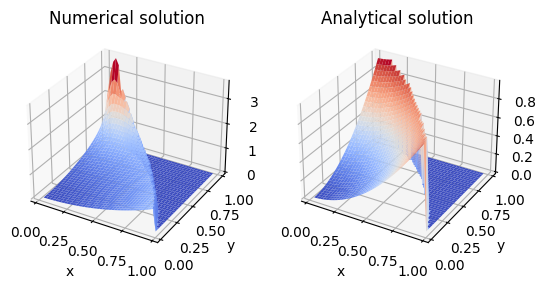

In [64]:
X, Y, u = solve(g, f4, M, modified_scheme=True, h=1/M)

x_grid = X[0, :]
h = x_grid[1] - x_grid[0]

# TODO: create a separate function perfoming this tast vvvvvv
# Find the number of interior points at each y
endpoint_at_row = np.zeros(M-1, dtype=np.int64)
for i, x in enumerate(x_grid[1:-1]):
    n = (np.sqrt(1-x)-np.sqrt(1-x)%h)/h
    endpoint_at_row[i] = endpoint_at_row[i-1]
    endpoint_at_row[i] += n if n*h != np.sqrt(1-x) else n-1

_, (ax1, ax2) = subplots_3d(ncols=2)

exact_sol = unpack_interior_nodes(pack_interior_nodes(T4(X, Y), endpoint_at_row), endpoint_at_row)

plot_solution(X[1:-1, 1:-1], Y[1:-1, 1:-1], u[1:-1, 1:-1], ax1, "Numerical solution")
plot_solution(X[1:-1, 1:-1], Y[1:-1, 1:-1], exact_sol[1:-1, 1:-1], ax2, "Analytical solution")